## Analyze A/B Test Results
<br>

<a id='toc'></a>
## Table of Contents
- [Introduction](#intro)
- [Part I - Data Wrangling](#data_wrangling)
- [Part II - Probability](#probability)
- [Part III - A/B Test](#ab_test)
- [Part IV - Regression](#regression)


<a id='intro'></a>
### Introduction

<p>For this project, I will be working to run an A/B test for the an e-commerce company. They want to increase user conversion rate through their web page. The goal is to work through this notebook to help the company understand if they should adopt the new page (which is newly made for them), keep the old page, or perhaps run the experiment longer to make their decision.</p>

<p>An experiment was run by the company on two groups of users, control and treatment. Control group was directed to the old page when they sign-in. Treatment group was directed to the new page when they sign-in.</p>

<p>The dataset provided is a table ('ab_data.csv' file) which has results of this experiment. There are five columns (fields):</p>
<br>
- user_id: id of the user.<br>
- timestamp: time of signing in.<br>
- group: group of which user belongs<br>
- landing_page: page which user is directed to.<br>
- converted: whether ot not the user converted.


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

[Top](#toc)
<a id='data_wrangling'></a>
### Part I - Data Wrangling


`1.` Exloratory Analysis<br><br> 
a. Read in the dataset and take a look at the top few rows

In [3]:
df = pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset

In [6]:
df.shape[0]

294478

c. The number of unique users in the dataset

In [7]:
no_users = df['user_id'].nunique()
print(no_users)

290584


d. The proportion of users converted

In [8]:
df.groupby(['user_id']).converted.any().sum() / no_users

0.12104245244060237

f. Do any of the rows have missing values?

In [10]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` Wrong Entries<br><br>
For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Drop those rows with wrong entries.  Store the new dataframe in **df2**.

In [11]:
df2 = df.drop(index=df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index)

In [12]:
df2.drop(index=df2[(df2['group'] != 'treatment') & (df2['landing_page'] == 'new_page')].index, inplace=True)

In [13]:
df2.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [14]:
# Double Check all of the correct rows were removed - this should be 0
(df2[df2['group'] == 'treatment'].landing_page != 'new_page').sum() + (df2[df2['group'] != 'treatment'].landing_page == 'new_page').sum()

0

`3.` Drop duplicates

a. How many unique **user_id**s are in **df2**?

In [15]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.

In [16]:
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. The row information for the duplicates

In [17]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the duplicated rows 

In [18]:
df2.drop(index=1899, inplace=True)

In [19]:
df2.shape[0]

290584

In [20]:
df2.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

<br>Saving df2 dataframe to a csv file

In [32]:
df2.to_csv('df2.csv', index=False)

[Top](#toc)
<a id='probability'></a>
### Part II - Probability


a. Probability of an individual converting regardless of the page they receive

In [15]:
convert_prob = df2.converted.sum() / df2.user_id.count()
print(convert_prob)

0.119597087245


In [25]:
control_df = df2.query('group == "control"')
control_prob = control_df['group'].count() / df2.shape[0]
print('P(control)= ', control_prob)

P(control)=  0.499938055777


b. Probability of an individual converting given that an individual was in the `control` group

In [26]:
conv_control_prob = control_df['converted'].sum() / control_df.shape[0]
print('P(conversion, control)= ',conv_control_prob)

P(conversion, control)=  0.1203863045


c. Probability of an individual converting given that an individual was in the `treatment` group

In [27]:
treatment_df = df2.query('group == "treatment"')
treatment_prob = treatment_df['group'].count() / df2.shape[0]
print('P(treatment)= ', treatment_prob)

conv_treatment_prob = treatment_df['converted'].sum() / treatment_df.shape[0]
print('P(conversion, treatment)= ', conv_treatment_prob)

P(treatment)=  0.500061944223
P(conversion, treatment)=  0.118808065515


In [44]:
obv_diff = conv_treatment_prob - conv_control_prob
obv_diff

-0.0015782389853555567

d. **the probability that an individual received the new page**

In [29]:
newpage_prob = (df2.landing_page == 'new_page').sum() / df2.shape[0]
print(newpage_prob)

0.500061944223


#### Conlusion:
I don't have sufficient evidence to conclude that the new treatment page leads to more conversions. Conversion rate for both control and treament groups are almost equal.<br>


[Top](#toc)
<a id='ab_test'></a>
### Part III - A/B Test

`1.` We need to make the decision just based on the data provided.  If we assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

**Null and Altertative Hypotheses:**<br>
$$H_0 = p_{new} - p_{old} <= 0 $$ <br>
$$H_1 = p_{new} - p_{old} > 0 $$<br>
$p_{new}$ is the probability of the new page and<br>
$p_{old}$ is the probability of the old page

### `2.` Bootstrapping
we assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume they are equal to the **converted** rate in the data provided regardless of the page. <br>

Using a sample size for each page equal to the ones in the data provided.  <br>

I will use Bootstrapping to perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

a. The **conversion rate** for $p_{new}$ under the null

In [31]:
convert_prob

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null

In [32]:
convert_prob

0.11959708724499628

c. $n_{new}$, the number of individuals in the treatment group

In [30]:
treatment_df.shape[0]

145310

d. $n_{old}$, the number of individuals in the control group?

In [33]:
control_df.shape[0]

145274

e. I simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null using bootstrapping and store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [54]:
treatment_size = treatment_df.shape[0]
control_size = control_df.shape[0]

In [56]:
p_news = []
p_olds = []
p_diffs = []
for _ in range(10000):
    sample_old = control_df.sample(control_size, replace=True)
    old_page_converted = sample_old['converted'].values
    p_old = old_page_converted.sum() / old_page_converted.size
    sample_new = treatment_df.sample(treatment_size, replace=True)
    new_page_converted = sample_new['converted'].values
    p_new = new_page_converted.sum() / new_page_converted.size
    p_news.append(p_new)
    p_olds.append(p_old)
    p_diffs.append(p_new - p_old)

In [60]:
new_page_converted = np.random.normal(convert_prob, np.std(p_news), treatment_size)

f. I simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null using bootstrapping and store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [61]:
control_size = control_df.shape[0]

old_page_converted = np.random.normal(convert_prob, np.std(p_olds), control_size)

g. I compute $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [63]:
new_page_converted = np.array(new_page_converted)
old_page_converted = np.array(old_page_converted)
p_new = new_page_converted.sum() / new_page_converted.size
p_old = old_page_converted.sum() / old_page_converted.size
p_new - p_old

-3.0845980455856958e-06

h. Now, we create 10,000 $p_{new}$ - $p_{old}$ values from the distribution produced by the simulation process we performed in parts (a) through (g) above. We store all 10,000 values in a numpy array called **p_diffs**.

In [64]:
p_diff = np.random.normal(0, np.std(p_diffs), 10000)

i. The histogram of the **p_diffs**

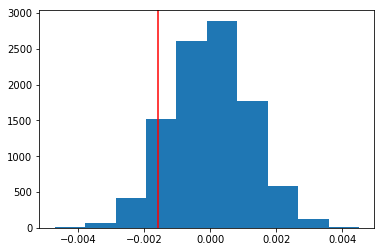

In [67]:
plt.hist(p_diff);
plt.axvline(obv_diff, color='red');

j. Proportion of the **p_diffs** that are greater than the actual difference observed in provided data, i.e. the p-value:

In [69]:
(p_diff > obv_diff).mean()

0.90720000000000001

**Conclusion:**<br><br>
- The computed p-value is greater than the allowed Type I error (0.05). 
- Therefore, we don't reject the null hypothesis which states that no difference between the new and old pages. 
- Therefore, there is no statistical significance for the alternative hypothesis.<br>

**Adopting the new page does not increase the conversion rate**

<br>We could also use a statistical test from statsmodel library to achieve similar results.  <br><br>
Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [70]:
#import statsmodels.api as sm

convert_old = old_page_converted.sum()
convert_new = new_page_converted.sum()
n_old = old_page_converted.size
n_new = new_page_converted.size

I use `stats.proportions_ztest` to compute your test statistic and p-value.

In [72]:
from statsmodels.stats.proportion import proportions_ztest
counts = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])
stat, pval = proportions_ztest(counts, nobs, value=0, alternative='larger', prop_var=p_diff.var())
print('p-value = {0:0.3f}'.format(pval))

p-value = 0.757


We don't reject the null hypothesis, conversion rates for new pages are less than or equal to the conversion rates of the old pages.
<br><br>
The results agree with my findings in parts j and k


[Top](#toc)
<a id='regression'></a>
### Part IV - A regression approach

a. In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**Logistic Regression (Classification)**

b. The goal is to fit logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.

Reading df2 from csv file

In [5]:
df2 = pd.read_csv('df2.csv')

In [6]:
df2['intercept'] = 1
df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [7]:
df2['ab_page'] = pd.get_dummies(df2['group']).iloc[:,1]

In [8]:
df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. I use **statsmodels** to instantiate the regression model on the two columns you created in part b., then fit the model to predict whether or not an individual converts. 

In [9]:
import statsmodels.api as sm

logistic_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logistic_model.fit()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Summary of the model

In [10]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-03 14:29 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

<br>**Results and conclusion**<br><br>p-value associated with ab_page variable= 0.1899.<br><br> Here the null and alternative hypotheses are: whether or not the exploratory variable, i.e. (ab_page) is significate for predicting the dependent variable, i.e. (converted). Because p-value is greater than default Type I error rate (0.05), therefore we don't regect the null hypothesis, i.e. we cannot predict whether or not a user converts using the provided variable (ab_page).

**There is no significant difference in conversion based on which page a customer receives.**

### Discussion
- I think it's a good idea to consider other factors such as (old user or new user) because old users could add a bias (they may get used to the old page, or get more attracted to the new page). 

<br>Note: Adding additional terms into the model could be disadvantageouse if there is comultilinearity between additional terms and existing terms in the model.

g. Now along with testing if the conversion rate changes for different pages, we also add an effect based on which country a user lives in using the **countries.csv** 

In [11]:
countries_df = pd.read_csv('countries.csv')

In [12]:
df2 = df2.join(countries_df.set_index('user_id'), on='user_id')
df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [14]:
df2['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

<br>I choose the baseline country to be US

In [17]:
df2[['country_2', 'country_3']] = pd.get_dummies(df2['country']).iloc[:,:-1]
df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,country_2,country_3
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0


In [18]:
df2.to_csv('df2.csv', index=False)

In [20]:
lg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'country_2', 'country_3']])
results = lg.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [21]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-03 14:39 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
country_2    -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
country_3     0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [34]:
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

<br>**Results and Conclusion**<br>
- If the user from UK, he is less likely to convert by 4% from the baseline (being from US) given that all other variables are constant.
- If the user from CA, he is more likely to convert by 1% from the baseline (being from US) given that all other variables are constant.

<br>**The effect based on which country a user lives has a very small impact**

h. Now I will look at an interaction between page and country to see if there significant effects on conversion.

In [28]:
df2['page_country_2'] = df2['country_2'].values * df2['ab_page'] 
df2['page_country_3'] = df2['country_3'].values * df2['ab_page'] 
df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,country_2,country_3,page_country_2,page_country_3
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,0,0


In [29]:
lg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'country_2', 'country_3', 'page_country_2', 'page_country_3']])
results = lg.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [30]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-03 15:07 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.9865   0.0096 -206.3440 0.0000 -2.0053 -1.9676
ab_page          -0.0206   0.0137   -1.5052 0.1323 -0.0473  0.0062
country_2        -0.0175   0.0377   -0.4652 0.6418 -0.0914  0.0563
country_3        -0.0057   0.0188   -0.3057 0.7598 -0.0426  0.0311
page_country_2   -0.0469   0.0538   -0.8718 0.3833 -0.1523  0.0585
page_country_3    0.0314   0.0266    1.1807 0.2377 -0.0207  0.0835
==================================================================

"""

**Results and Conclusion**<br>p-values for both interaction terms (page_country_2, page_country_3) are more than 0.05. Therefore these terms have no significant effects on user conversion.